#### Lab : Regularization and Linear models

In [3]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)
from l0bnb import fit_path
import matplotlib.pyplot as plt

#### Subset Selection : 
- Forward
- Backward
- Mixed

### Forward Selection

_Dataset Description_

* `AtBat`: Number of times at bat in 1986
* `Hits`: Number of hits in 1986
* `HmRun`: Number of home runs in 1986
* `Runs`: Number of runs in 1986
* `RBI`: Number of runs batted in in 1986
* `Walks`: Number of walks in 1986
* `Years`: Number of years in the major leagues
* `CAtBat`: Number of times at bat during his career
* `CHits`: Number of hits during his career
* `CHmRun`: Number of home runs during his career
* `CRuns`: Number of runs during his career
* `CRBI`: Number of runs batted in during his career
* `CWalks`: Number of walks during his career
* `League`: A factor with levels A and N indicating player's league at the end of 1986
* `Division`: A factor with levels E and W indicating player's division at the end of 1986
* `PutOuts`: Number of put outs in 1986
* `Assists`: Number of assists in 1986
* `Errors`: Number of errors in 1986
* `Salary`: 1987 annual salary on opening day in thousands of dollars
* `NewLeague`: A factor with levels A and N indicating player's league at the beginning of 1987

Here probably we are going to see how the salary is influenced

In [26]:
data = load_data("Hitters")
data_new = data.dropna()
data_new.shape

(263, 20)

We are doing model selection using $C_p = \frac{\text{RSS} + 2p(\sigma^2)}{n}$ but `sklearn` doesn't define it. So we need to compute it ourselves. 

Function : 
- `sklearn_selected(model, strategy).fit(data, y)` -> Expects a scorer with just 3 arguments
- `Stepwise()` -> To specify the search strategy
- `Stepwise.first_peak(design, direction, max_terms)` -> Runs forward stepwise until forward stepwise don't result in any improvements

In [49]:
def C_p(sigma2, estimator, x, y) : 
    n, p = x.shape
    Yhat = estimator.predict(x)
    RSS = np.sum((y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

# Design Matrix
design = MS(data_new.columns.drop("Salary")).fit(data_new)
x = design.transform(data_new)
y = data_new["Salary"]
sigma = sm.OLS(y, x).fit().scale

# Fixing
neg_cp = partial(C_p, sigma)

# # Defining the strategy
forward = Stepwise.first_peak(design, direction="forward", max_terms=len(design.terms))
model_forward = sklearn_selected(sm.OLS, forward, scoring = neg_cp)
model_forward.fit(data_new.drop("Salary", axis=1), y)
model_forward.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

Choosing models using `Validation` & `CrossValidation`, but to implement this we need something that can store the full path of the models and we can estimate error using the full path. 
- `sklearn_selection_path()` & `cross_val_predict()` computes the cross validated predictions

Using CV to make the determination of which model of a given size is best must be made using training observations

In [10]:
strategy = Stepwise.fixed_steps(design, len(design.terms), direction = "forward")
full = sklearn_selection_path(sm.OLS, strategy, scoring=neg_cp)
full.fit(data_new, y)
yhat = full.predict(data_new)
yhat.shape # Fitted value of the array of the full path.

NameError: name 'X' is not defined

In [7]:
kfold = skm.KFold(5, shuffle = True, random_state = 0)
yhat_cv = skm.cross_val_predict(full, data_new, y, cv = kfold)
cv_mse = []

for train_idx, test_idx in kfold.split(y) : 
    errors = ((yhat_cv[test_idx] - y[test_idx][:, None])**2).mean(0)
    cv_mse.append(errors)
    
cv_mse = np.array(cv_mse).T
cv_mse.shape


KeyError: '[22, 83, 101, 106, 125, 150, 158, 171, 253] not in index'

In [9]:
valfold = skm.ShuffleSplit(1, random_state = 0)
val_mse = []

for train_idx, test_idx in valfold.split(y) : 
    full.fit(data_new.iloc[train_idx], y[train_idx])
    yhat_val = full.predict(data_new.iloc[test_idx])
    errors = ((yhat_val - y[test_idx][:, None])**2).mean(0)
    val_mse.append(errors)
    
val_mse = np.array(val_mse).T
val_mse.shape

KeyError: '[171, 22, 83, 158, 101, 44, 64, 71, 157, 15, 97, 18, 228, 250, 254, 103, 52, 66, 235, 30, 144, 80, 104, 173, 246, 41, 160, 138, 0, 94, 69, 48, 199, 225, 57, 169, 42, 105, 38, 210, 114, 203, 32, 197, 208, 77, 39, 36] not in index'

AttributeError: 'list' object has no attribute 'mean'

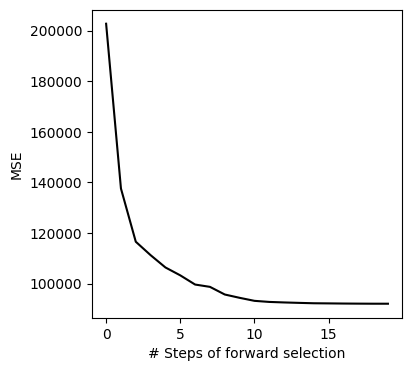

In [11]:
# Plotting the MSE
mse, ax = subplots(figsize = (4,4))
y = np.array(data_new["Salary"])
mse_sample = np.array((yhat -y[:, None])**2).mean(0) # y[:,None] -> make a column vector.
n = mse_sample.shape[0]
ax.plot(np.arange(n),mse_sample, label = "In-Sample", color = "k")
ax.set_xlabel("# Steps of forward selection")
ax.set_ylabel("MSE")
ax.errorbar(np.arange(n), cv_mse.mean(1), cv_mse.std(1)/ np.sqrt(5), label = "CrossValidation", c = "r")
ax.plot(np.arange(n), val_mse.mean(1), label = "Validation", c = "y")
ax.legend()
plt.show()

Best subset selection using `l0bnb` & `fit_path`

In [ ]:
# Beyond scope of this book
d = design.fit_transform(data_new)
de = d.drop("intercept", axis = 1)
x = np.asarray(de)
path = fit_path(x,y,max_nonzeros=x.shape[1])
path

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


[{'B': array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.77543616, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ]),
  'B0': 279.70762133645695,
  'lambda_0': 0.1559978371476548,
  'M': 0.5558487113898553,
  'Time_exceeded': False},
 {'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.67775265, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ]),
  'B0': -38.98216739555551,
  'lambda_0': 0.04917594600171587,
  'M': 0.6670111294490764,
  'Time_exceeded': False},
 {'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.67775265, 0.        , 0.        , 0.        ,
         0.  

#### Penalization
- Rigde
- Lasso

Function : 
1. `skl.ElasticNet()` : to fit both ridge and lasso
2. `skl.ElasticNet().path()` : can fit the hybrid mixture

Lasso is scale dependent so you need to first Standardize and then unstandardize the coefficients.

In [ ]:
xs = x - x.mean(0)[None, :]
xscale = x.std(0)
xscaled = xs / xscale[None, :]  

lambdas = 10 ** np.linspace(8,-2,100) / y.std()

soln_array = skl.ElasticNet.path(xs, y, l1_ratio=0.0, alphas=lambdas)[1]
soln_path = pd.DataFrame(soln_array.T, columns = de.columns, index = -np.log(lambdas))
soln_path.index.name = "- log(lambda)"

# Plotting 
path_fig, ax = subplots(figsize = (8,8))
soln_path.plot(ax = ax, legend=False)
ax.set_xlabel("- log(lambda)")
ax.set_ylabel("Standardized Coefficients")
plt.show()

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

In [ ]:
lambdas = 10 ** np.linspace(8,-2,100) / y.std()
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], np.linalg.norm(beta_hat) # Getting the lambda and the beta_hat values

NameError: name 'soln_path' is not defined

In [ ]:
# Using the pipeline
lambdas = 10 ** np.linspace(8,-2,100) / y.std()
ridge = skl.ElasticNet(alpha = lambdas[59], l1_ratio = 0.0)
scaler = StandardScaler(with_mean = True, with_std = True)
pipe = Pipeline([("scaler", scaler), ("ridge", ridge)])
pipe.fit(x,y)
np.linalg.norm(pipe.named_steps["ridge"].coef_) # Getting the beta_hat values

/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+07, tolerance: 5.332e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


160.51831520252574

#### Estimating the test error of ridge

Choosing a prior $\lambda$ value is very important for ridge, we usually do it by cross validation. 
We can use the `Pipeline()` approach in `skm.cross_validate()`

We can use `GridSearchCV()` which will allow us to do comprehensive grid search to choose the best parameter

Each fold in `GridCV()` is standardized individually, there could be discrepancy in the results, but in `Pipeline()` based approach it is carried out only once

`NestedCV()` Cross validation at some point uses all the data, around 25% of data is kept for testing purposes only

In [ ]:
# Validation approach

validation = skm.ShuffleSplit(1, test_size = 0.5, random_state = 0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge, x, y, scoring = "neg_mean_squared_error", cv = validation)
results["test_score"]

/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.486e+06, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([-134214.00419204])

In [ ]:
param_grid = {"ridge__alpha" : lambdas}
grid = skm.GridSearchCV(pipe, param_grid, scoring = "neg_mean_squared_error", cv = validation)
grid.fit(x,y)
grid.best_params_["ridge__alpha"]
grid.best_estimator_

NameError: name 'validation' is not defined

/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.244e+07, tolerance: 2.488e+03 Linear regression models with null wei

Text(0, 0.5, 'Cross Validated MSE')

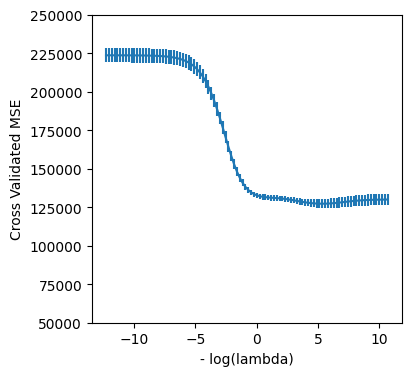

In [ ]:
# Using the KFold
kfold = skm.ShuffleSplit(5, test_size = 0.5, random_state = 0)
grid = skm.GridSearchCV(pipe, param_grid, scoring = "neg_mean_squared_error", cv = kfold)
grid.fit(x,y)
grid.best_params_["ridge__alpha"]

# Plotting
ridge_fig, ax = subplots(figsize = (4,4))
ax.errorbar(-np.log(lambdas), -grid.cv_results_["mean_test_score"], yerr = grid.cv_results_["std_test_score"] / np.sqrt(5))
ax.set_ylim([50000, 250000])
ax.set_xlabel("- log(lambda)")
ax.set_ylabel("Cross Validated MSE")

/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.244e+07, tolerance: 2.488e+03 Linear regression models with null wei

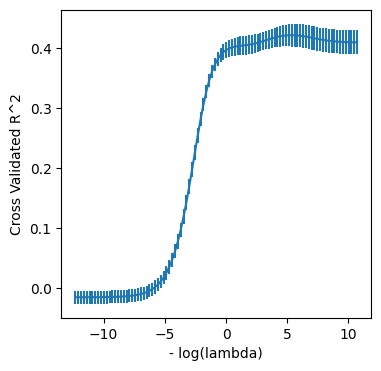

In [ ]:
## For R^2 comparison
grid_r2 = skm.GridSearchCV(pipe, param_grid, scoring = "r2", cv = kfold)
grid_r2.fit(x,y)

r2_fig, ax = subplots(figsize = (4,4))
ax.errorbar(-np.log(lambdas), grid_r2.cv_results_["mean_test_score"], yerr = grid_r2.cv_results_["std_test_score"] / np.sqrt(5))
ax.set_xlabel("- log(lambda)")
ax.set_ylabel("Cross Validated R^2")
plt.show()

/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11360050.27412681, tolerance: 2272.034006460339
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regu

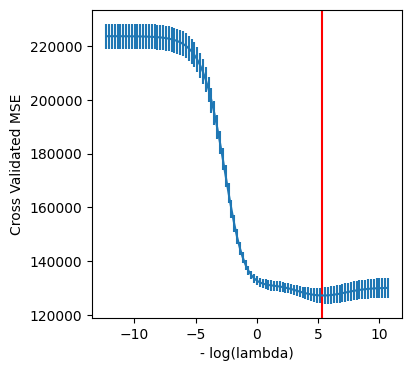

In [ ]:
ridgeCV = skl.ElasticNetCV(l1_ratio = 0.0, alphas = lambdas, cv = kfold)
pipeCV = Pipeline([("scaler", scaler), ("ridge", ridgeCV)])
pipeCV.fit(x,y)

tuned_ridge = pipeCV.named_steps["ridge"]

r2_fig, ax = subplots(figsize = (4,4))
ax.errorbar(-np.log(lambdas), tuned_ridge.mse_path_.mean(1), yerr =  tuned_ridge.mse_path_.std(1) / np.sqrt(5))
ax.axvline(-np.log(tuned_ridge.alpha_), c = "r")
ax.set_xlabel("- log(lambda)")
ax.set_ylabel("Cross Validated MSE")
plt.show()

In [ ]:
# What is the \lambda value for min MSE 
np.min(tuned_ridge.mse_path_.mean(1)), tuned_ridge.alpha_

# Getting the coefficients -> None of are zero.
tuned_ridge.coef_

array([-264.97207276,  288.86711419,   15.6421743 ,  -25.09894758,
         -7.0220354 ,  122.41857935,  -41.27353538, -203.38610906,
        127.40194443,   43.49677069,  300.85148172,  151.28105936,
       -179.77327676,   30.94372861,  -60.49400301,   78.5265124 ,
         46.38430414,  -23.97939773,  -13.75915381])

In [ ]:
# Nested CV
outer_valid = skm.ShuffleSplit(1, test_size = 0.25  , random_state = 0)
inner_cv = skm.KFold(5, shuffle = True, random_state = 0)
ridgeCV = skl.ElasticNetCV(l1_ratio = 0.0, alphas = lambdas, cv = inner_cv)
pipeCV = Pipeline([("scaler", scaler), ("ridge", ridgeCV)])
results = skm.cross_validate(pipeCV, x, y, scoring = "neg_mean_squared_error", cv = outer_valid)
results["test_score"]

""" Pipeline -->
Scaling -> 5,CV -> Ridge Regression -> Validation -> TestMSE
"""

/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14441653.72331704, tolerance: 2888.363493206679
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regu

' Pipeline -->\nScaling -> 5,CV -> Ridge Regression -> Validation -> TestMSE\n'

### Lasso

Can lasso yield a more interpretable model than ridge regression? 

In [ ]:
# Lasso
lassoCV = skl.ElasticNetCV(l1_ratio = 1.0, alphas = lambdas, cv = kfold)
pipeCV = Pipeline([("scaler", scaler), ("lasso", lassoCV)])
pipeCV.fit(x,y)

tuned_lasso = pipeCV.named_steps["lasso"]
tuned_lasso.alpha_

/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2749.8047167360783, tolerance: 2487.7264790993913
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2651.55026592128, tolerance: 2487.7264790993913
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2506.158292071

1.5668277892277

Text(0, 0.5, 'Standardized Coefficients')

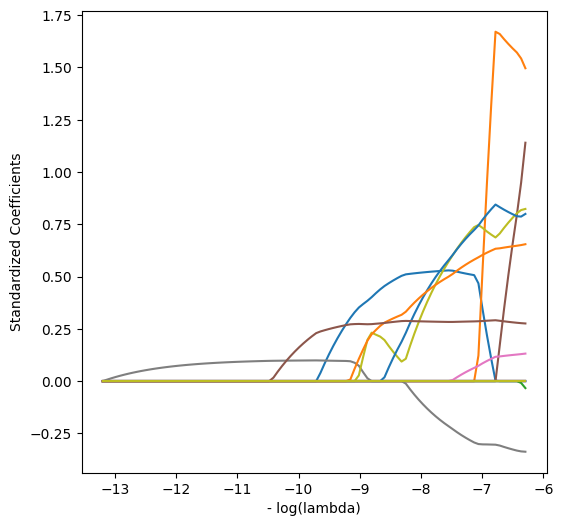

In [ ]:
lambdas, soln_array = skl.ElasticNet.path(xs, y, l1_ratio = 1.0, n_alphas = 100)[:2]
soln_path = pd.DataFrame(soln_array.T, columns = de.columns, index = -np.log(lambdas))

path_fig, ax = subplots(figsize = (6,6))
soln_path.plot(ax = ax, legend = False)
ax.set_xlabel("- log(lambda)")
ax.set_ylabel("Standardized Coefficients")

In [ ]:
np.min(tuned_lasso.mse_path_.mean(1)), tuned_lasso.alpha_

lassoCV_fig, ax = subplots(figsize = (4,4))
ax.errorbar(-np.log(tuned_lasso.alphas_), tuned_lasso.mse_path_.mean(1), yerr = tuned_lasso.mse_path_.std(1) / np.sqrt(5))
ax.axvline(-np.log(tuned_lasso.alpha_), c = "r", ls = "--")
ax.set_xlabel("- log(lambda)")
ax.set_ylabel("Cross Validated MSE")
ax.set_ylim([50000, 250000])

# Resulting coefficients
tuned_lasso.coef_ # Only 0 are zero, some sort of variable selection

NameError: name 'tuned_lasso' is not defined

In [ ]:
"""
Scaling -> 5,CV -> Lasso Regression -> Validation -> TestMSE
"""

outer_valid = skm.ShuffleSplit(1, test_size = 0.25  , random_state = 0)
inner_cv = skm.KFold(5, shuffle = True, random_state = 2)
lassoCV = skl.ElasticNetCV(l1_ratio = 1.0, alphas = lambdas, cv = inner_cv)
pipeCV = Pipeline([("scaler", scaler), ("ridge", lassoCV)])
results = skm.cross_validate(pipeCV, x, y, scoring = "neg_mean_squared_error", cv = outer_valid)

results["test_score"]

NameError: name 'lambdas' is not defined

#### PCR & PLS

Primarily we will be using pipeline here `Pipeline()` & `PCA`
- `pipe.named_steps["pca"].explained_variance_ratio` -> Gives the variance expalined by each component

In [ ]:
pca = PCA(n_components = 2)
linreg = skl.LinearRegression()
pipe = Pipeline([("scaler", scaler),("pca", pca), ("linreg", linreg)])
pipe.fit(x,y)
pipe.named_steps["linreg"].coef_

array([106.36859204,  21.60350456])

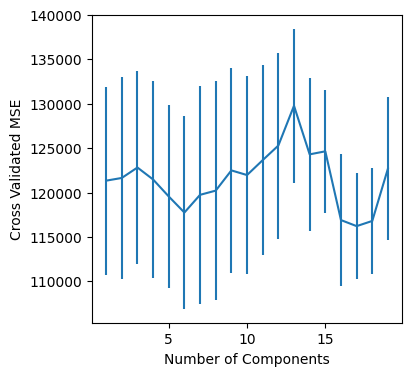

In [ ]:
# Using CV to get the number of components
param_grid  = {"pca__n_components" : range(1,20)}
grid = skm.GridSearchCV(pipe, param_grid, scoring = "neg_mean_squared_error", cv = kfold)
grid.fit(x,y)

# Plotting - best for 17.
pca_fig, ax = subplots(figsize = (4,4))
ax.errorbar(range(1,20), -grid.cv_results_["mean_test_score"], yerr = grid.cv_results_["std_test_score"] / np.sqrt(5))
ax.set_xlabel("Number of Components")
ax.set_ylabel("Cross Validated MSE")
plt.show()

In [ ]:
pipe.named_steps["pca"].explained_variance_ratio_

array([0.3831424 , 0.21841076])

In [ ]:
# Partial Least Squares
pls = PLSRegression(n_components = 2, scale=True)
pls.fit(x,y)

PLSRegression()

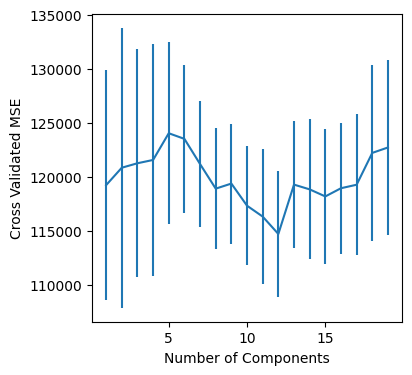

In [ ]:
param_grid = {"n_components" : range(1,20)}
grid = skm.GridSearchCV(pls, param_grid, scoring = "neg_mean_squared_error", cv = kfold)
grid.fit(x,y)

# It find the best estimator for as 12 components
# Plotting
pls_fig, ax = subplots(figsize = (4,4))
ax.errorbar(range(1,20), -grid.cv_results_["mean_test_score"], yerr = grid.cv_results_["std_test_score"] / np.sqrt(5))
ax.set_xlabel("Number of Components")
ax.set_ylabel("Cross Validated MSE")
plt.show()